In [1]:
import os
import zipfile
import random
import shutil
from shutil import copyfile

import tensorflow as tf
import numpy as np
import matplotlib as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from stn import spatial_transformer_network as transformer
import matplotlib.pyplot as plt


## maybe use the layers.add function instead?

that way for the localization layer, we can get the shape of the last convolution layer and somehow add that to the into the transformer? I still don't get what that part is doing

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(256,256,3)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    # tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten()
    ])


# x = tf.zeros([256,256,3], tf.int32)
# identity = np.array([[1., 0., 0.],
#                     [0., 1., 0.]]) 
# identity = identity.flatten()
# theta = tf.Variable(initial_value=identity)
# model.add(transformer(x, theta))
#     tf.keras.layers.Dense(32, activation="relu"),
#     localization layer? then transformer? idk what happens here


model.add(tf.keras.layers.Dense(1024, activation="relu"))

model.add(tf.keras.layers.Dense(512, activation="relu"))

model.add(tf.keras.layers.Dense(7, activation="softmax"))


# Model option 2, large scale object classification

In [3]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(96, (11,11), activation="relu", input_shape=(256,256,3), strides=(4,4)),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     tf.keras.layers.Conv2D(256, (5,5), activation="relu"),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     tf.keras.layers.Conv2D(512, (3,3), activation="relu"),
#     # tf.keras.layers.ZeroPadding2D(1, input_shape=(1,1,1)),
#     tf.keras.layers.Conv2D(1024, (3,3), activation="relu"),
#     # tf.keras.layers.ZeroPadding2D(1, input_shape=(1,1,1)),
#     tf.keras.layers.Conv2D(1024, (3,3), activation="relu"),
#     # tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     # tf.keras.layers.ZeroPadding2D(1, input_shape=(1,1,1)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(3072, activation="relu"),
#     tf.keras.layers.Dense(4096, activation="relu"),
#     tf.keras.layers.Dense(7, activation="softmax"),
#     ])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 64)        0

In [5]:

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['acc'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "emotions/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,)
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, target_size=(256,256), 
batch_size=32, class_mode="categorical")

VALIDATION_DIR = "emotions/test/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(256,256),batch_size=32, class_mode="categorical")



Found 10004 images belonging to 7 classes.
Found 1133 images belonging to 7 classes.


Bonnie_surprise_1389 image was corrupt, had to be removed

In [13]:
history = model.fit(train_generator,
                            epochs=1,
                            verbose=1,  
                            validation_data=validation_generator)


313/313 [==============================] - 46s 147ms/step - loss: 0.0324 - acc: 0.9909 - val_loss: 1.1848e-04 - val_acc: 1.0000


In [14]:
dir_ = "img_test"


li = np.array(os.listdir(dir_))
pic = li[0]
img_path = os.path.join(dir_, pic)

img = image.load_img(img_path, target_size=(256,256))
x = image.img_to_array(img)
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)


(256, 256, 3)
(1, 256, 256, 3)


The top down order of the data in the train/test directories is the order of the predictions.
The first item in the list shows the percent prediction for angry.

[[1. 0. 0. 0. 0. 0. 0.]]


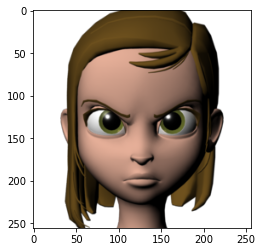

In [15]:

import matplotlib.image as mpimg

i = mpimg.imread(img_path)
plt.imshow(i)
c = model.predict(x)
print(c)

In [10]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")



NameError: name 'history' is not defined